In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/My Drive/google_colab_gpu/CMS_Graphs

/content/drive/My Drive/google_colab_gpu/CMS_Graphs


In [ ]:
import numpy as np
np.random.seed(0)
import os, glob
import time
import datetime
import h5py
import tensorflow.keras as keras
import math
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
#from novograd import NovoGrad
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    print()
    #tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')

USE_XLA = True
if USE_XLA:
    tf.config.optimizer.set_jit(USE_XLA)
    #reference url : https://www.tensorflow.org/xla
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)



INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [ ]:
epochs = 3
lr_init = 0.001
resblocks = 3
cuda = 0
start_epoch = 0
save_dir = 'MODELS_BTJ_TF'
warmup_epochs = 5
expt_name = 'BoostedJets-opendata_ResNet_blocks%d_x1_epochs%d'%(resblocks, epochs)
expt_name = expt_name + '-' +  datetime.date.strftime(datetime.datetime.now(),"%Y%m%d-%H%M%S")
verbose = 1

In [ ]:
# Path to directory containing TFRecord files
datafile = glob.glob('./data_shared/BoostedTopJets_0_400/*') #datafile = tf.data.Dataset.list_files('/home/u00u5ev76whwBTLvWe357/multiGPU/tfrecord_x1/*')
test_datafile = glob.glob('./data_shared/BoostedTopJets_401_800/*') #datafile = tf.data.Dataset.list_files('/home/u00u5ev76whwBTLvWe357/multiGPU/tfrecord_x1/*')

In [ ]:
def LR_Decay(epoch):
    drop = 0.5
    epochs_drop = 10
    lr = lr_init * math.pow(drop, math.floor((epoch+1)/epochs_drop))
    return lr

def restart_epoch(epochs):
    epoch = 0
    for try_epoch in range(epochs, 0, -1):
        if os.path.exists(expt_name.format(epoch=try_epoch)):
            epoch = try_epoch
            break

    return epoch

In [ ]:
BATCH_SZ = 64
train_sz = 3200*200#*80000
valid_sz = 3200*40
test_sz  = 3200*20

valid_steps = valid_sz // (BATCH_SZ)#*hvd.size())
test_steps  = test_sz  // (BATCH_SZ)#*hvd.size())

In [ ]:
channels = [0,1,2,3,4,5,6,7]
granularity=3

In [ ]:
# Mapping functions used to convert tfrecords to tf dataset
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#@nvtx_tf.ops.trace(message='ExtractFromTFRecord', domain_name='DataLoading', grad_domain_name='BoostedJets')
def extract_fn(data):
    # extracts fields from TFRecordDataset
    feature_description = {
        'X_jets': tf.io.FixedLenFeature([125*granularity*125*granularity*8], tf.float32),
        #'m0': tf.io.FixedLenFeature([], tf.float32), 
        #'pt': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32)
    }
    sample = tf.io.parse_single_example(serialized=data, features=feature_description)
    return sample

classes = 2
def map_fn(data):
    # reshapes X_jets, converts y to one-hot array for feeding into keras model
    x = tf.reshape(data['X_jets'], (125*granularity,125*granularity,8))[...,0:]
    y = tf.one_hot(tf.cast(data['y'], tf.uint8), classes)
    return x, y

def x_fn(data):
    return tf.reshape(data['X_jets'], (125*granularity,125*granularity,8))[...,0:]

def y_fn(data):
    return data['y']

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        print("\n Timestamp: "+str(tf.cast(tf.timestamp(),tf.float64)))

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# creates training dataset containing first data_size examples in datafile
# - datafile: name (or list of names) of TFRecord file containing training data
#@nvtx_tf.ops.trace(message='train_dataset', domain_name='DataLoading', grad_domain_name='BoostedJets')
def train_dataset_generator(dataset, is_training=True, batch_sz=32, columns=[0,1,2], data_size = 32*10000):
    if is_training:
        print("Stage1 shuffle time: "+str(tf.cast(tf.timestamp(),tf.float64)))
        dataset = dataset.shuffle(batch_sz * 2)
        print("Stage2 shuffle time: "+str(tf.cast(tf.timestamp(),tf.float64)))
    print("Stage1 map+shuffle+repeat+batch+prefetch time: "+str(tf.cast(tf.timestamp(),tf.float64)))
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_sz, drop_remainder=True if is_training else False).repeat().prefetch(tf.data.experimental.AUTOTUNE)
    print("Stage2 map+shuffle+repeat+batch+prefetch time: "+str(tf.cast(tf.timestamp(),tf.float64)))
    #dataset = dataset.map(map_fn,num_parallel_calls=NUM_WORKERS).batch(batch_sz, drop_remainder=True if is_training else False)
    # dataset = dataset.repeat()
    # dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    #dataset = dataset.apply(tf.data.experimental.ignore_errors())

    return dataset

In [ ]:
# creates training dataset containing first data_size examples in datafile
# - datafile: name (or list of names) of TFRecord file containing training data
#@nvtx_tf.ops.trace(message='get_dataset', domain_name='DataLoading', grad_domain_name='BoostedJets')
def get_dataset(dataset, start, end, batch_sz=32, columns=channels):
    dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_sz, drop_remainder=False).repeat().prefetch(tf.data.experimental.AUTOTUNE)
    #dataset = dataset.map(map_fn, num_parallel_calls=NUM_WORKERS).batch(batch_sz, drop_remainder=False)
    #dataset = dataset.repeat()
    #dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    #dataset = dataset.apply(tf.data.experimental.ignore_errors())

    return dataset

#@nvtx_tf.ops.trace(message='test_dataset', domain_name='DataLoading', grad_domain_name='BoostedJets')
def test_dataset(dataset, start, end, batch_sz=32):
    X = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_sz, drop_remainder=False)
    #X = dataset.map(map_fn).batch(batch_sz, drop_remainder=False)
    Y = dataset.map(y_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(end-start)
    #Y = dataset.map(y_fn).batch(end-start)

    return X,Y

In [ ]:
#@nvtx_tf.ops.trace(message='Creat Resnet', domain_name='Resnet', grad_domain_name='BoostedJets')
def create_resnet():
    # Build network
    import Notebooks.models.keras_resnet_single as networks
    resnet = networks.ResNet.build(len(channels), resblocks, [16,32], (125*granularity,125*granularity,len(channels)), granularity)
    # Load saved weights, if indicated
    if start_epoch != 0:
        directory = save_dir
        if save_dir == '':
            directory = expt_name
        model_name = glob.glob('MODELS_BTJ_TF/%s/epoch%02d-*.hdf5'%(directory, start_epoch))[0]
        #assert len(model_name) == 2
        #model_name = model_name[0].split('.hdf5')[0]+'.hdf5'
        print('Loading weights from file:', model_name)
        resnet.load_weights(model_name)
    opt = keras.optimizers.Adam(lr=lr_init, epsilon=1.e-5) # changed eps to match pytorch value
    #opt = keras.optimizers.SGD(lr=lr_init * hvd.size())
    #opt = NovoGrad(learning_rate=lr_init * hvd.size())
    #Wrap the optimizer in a Horovod distributed optimizer -> uses hvd.DistributedOptimizer() to compute gradients.
    #opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
    #opt = hvd.DistributedOptimizer(opt)

    #For Horovod: We specify `experimental_run_tf_function=False` to ensure TensorFlow
    resnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], experimental_run_tf_function = False)
    #resnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    resnet.summary()
    return resnet

In [ ]:
#LOADING DATA
names = datafile
dataset = tf.data.TFRecordDataset(filenames=names, compression_type='GZIP', num_parallel_reads=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(extract_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_data = train_dataset_generator(dataset.take(train_sz), is_training=True, batch_sz=BATCH_SZ, columns=channels, data_size=train_sz)

for i,data in enumerate(train_data):
  print(i,data[0].shape)
  break


Stage1 shuffle time: tf.Tensor(1627484624.440001, shape=(), dtype=float64)
Stage2 shuffle time: tf.Tensor(1627484624.446824, shape=(), dtype=float64)
Stage1 map+shuffle+repeat+batch+prefetch time: tf.Tensor(1627484624.446965, shape=(), dtype=float64)
Stage2 map+shuffle+repeat+batch+prefetch time: tf.Tensor(1627484624.503054, shape=(), dtype=float64)
0 (64, 375, 375, 8)


pT tf.Tensor([1. 0.], shape=(2,), dtype=float32)


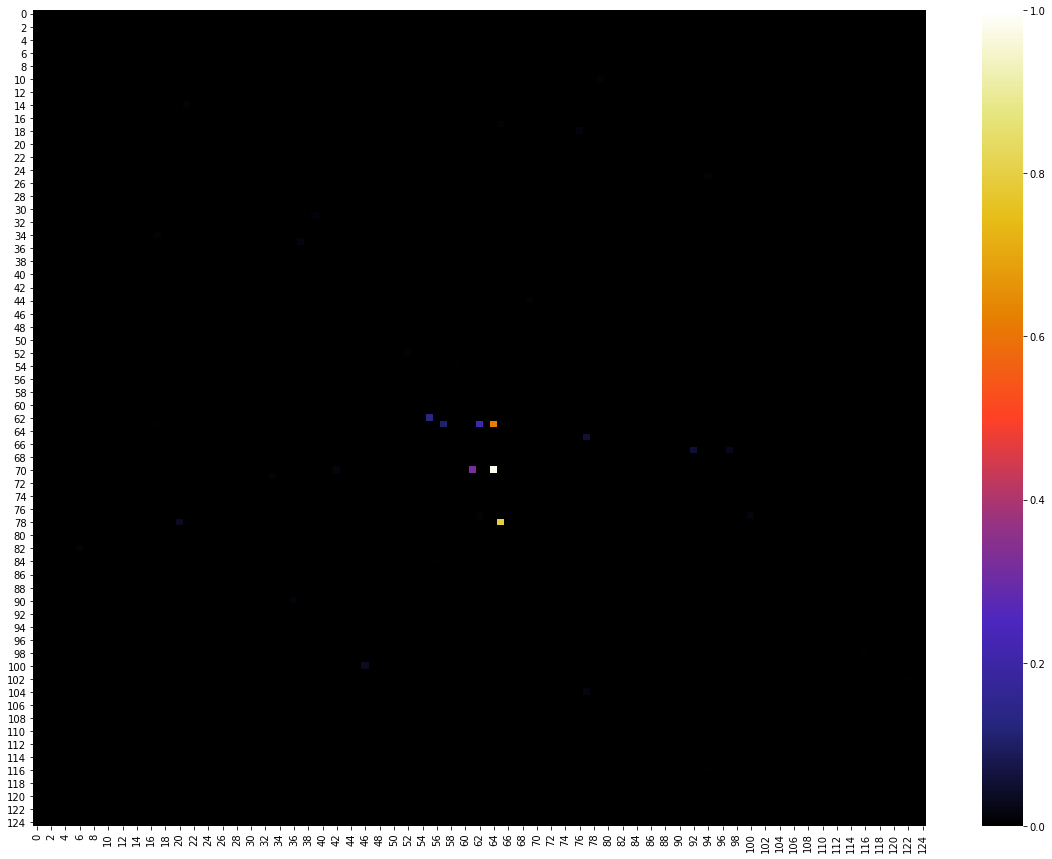

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
idx=1
plt.subplots(figsize=(20,15))
ax = sns.heatmap(data[0][idx,:,:,0], cmap="CMRmap", vmin=0, vmax=1)#, mask=mask_shower[0])#,linecolor="blue",linewidths=0.05)
print("pT",data[1][idx])#, max occ idx:",max_occ_idx,"max_occ: ",max_occ )

ECAL tf.Tensor([1. 0.], shape=(2,), dtype=float32)


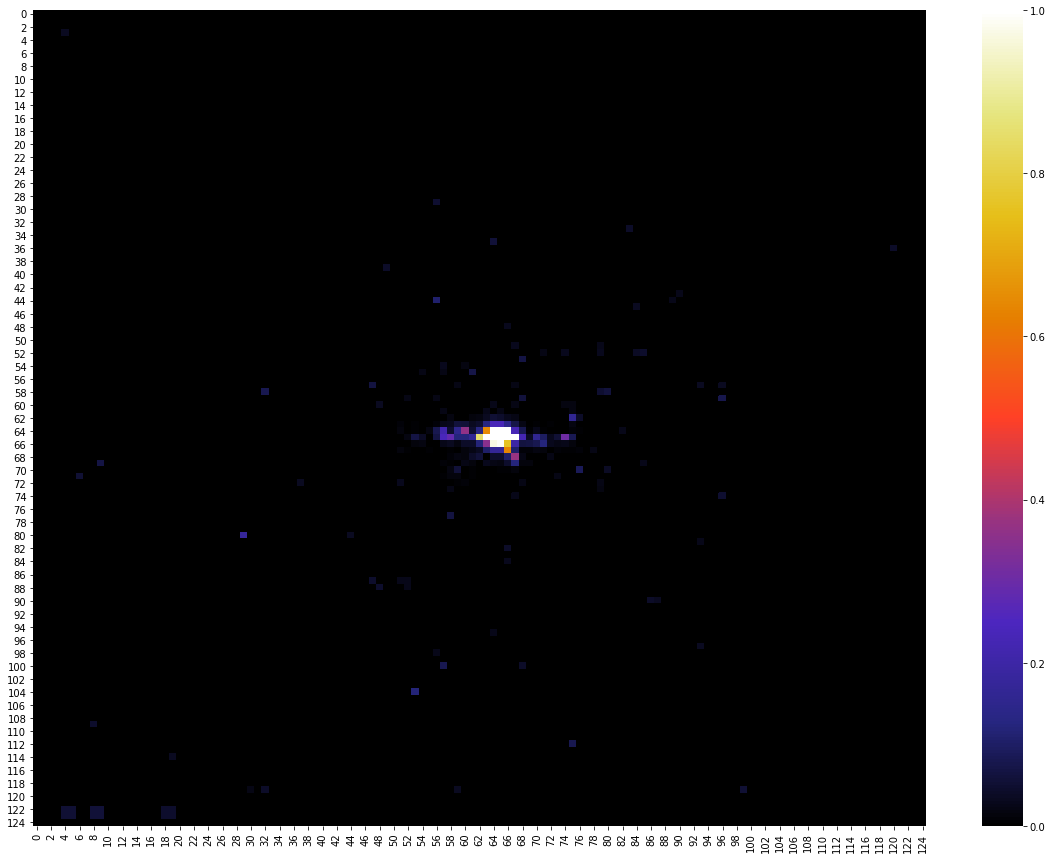

In [ ]:
plt.subplots(figsize=(20,15))
ax = sns.heatmap(data[0][idx,:,:,3], cmap="CMRmap", vmin=0, vmax=1)#, mask=mask_shower[0])#,linecolor="blue",linewidths=0.05)
print("ECAL",data[1][idx])#, max occ idx:",max_occ_idx,"max_occ: ",max_occ )

HCAL tf.Tensor([1. 0.], shape=(2,), dtype=float32)


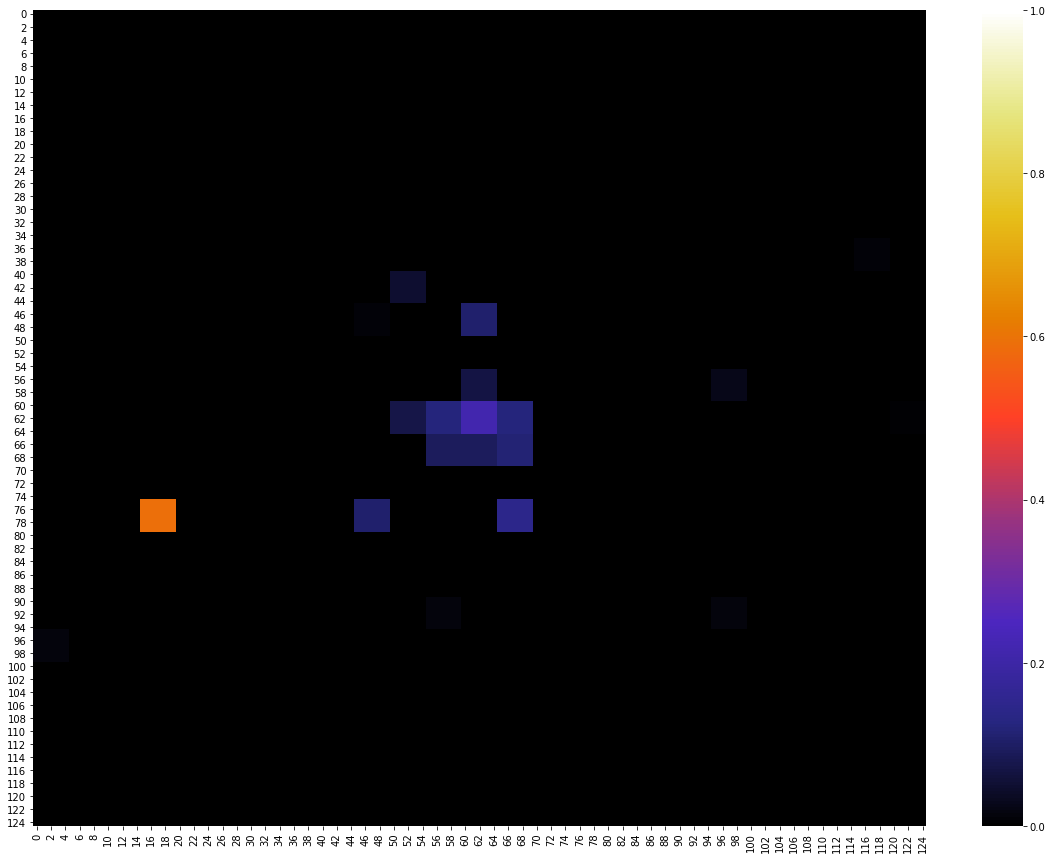

In [ ]:
plt.subplots(figsize=(20,15))
ax = sns.heatmap(data[0][idx,:,:,4], cmap="CMRmap", vmin=0, vmax=1)#, mask=mask_shower[0])#,linecolor="blue",linewidths=0.05)
print("HCAL",data[1][idx])#, max occ idx:",max_occ_idx,"max_occ: ",max_occ )

## Training x3 Boosted Top Data

In [ ]:
if __name__ == '__main__':
    decay = ''
    #print(">> Input file:",datafile)
    expt_name = '%s_%s'%(decay, expt_name)
    for d in ['MODELS_BTJ_TF', 'METRICS']:
        if not os.path.isdir('%s/%s'%(d, expt_name)):
            os.makedirs('%s/%s'%(d, expt_name))
    # Build network
    resnet = create_resnet()
    # Model Callbacks
    callbacks_list = []
    callbacks_list.append(myCallback())
    resume_from_epoch = 0
    callbacks_list.append(keras.callbacks.ModelCheckpoint('MODELS_BTJ_TF/' + expt_name + '/epoch{epoch:02d}.hdf5', verbose=verbose, save_best_only=False))#, save_weights_only=True)
    callbacks_list.append(keras.callbacks.TensorBoard(save_dir))
    resume_from_epoch = restart_epoch(epochs)
    #resume_from_epoch = hvd.broadcast(resume_from_epoch, 0)

    #LOADING DATA
    names = datafile
    dataset = tf.data.TFRecordDataset(filenames=names, compression_type='GZIP', num_parallel_reads=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(extract_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    train_data = train_dataset_generator(dataset.take(train_sz), is_training=True, batch_sz=BATCH_SZ, columns=channels, data_size=train_sz)

    val_data = get_dataset(dataset.skip(train_sz).take(valid_sz), start=train_sz, end=train_sz+valid_sz, batch_sz= BATCH_SZ, columns=channels)
    test_data = test_dataset(dataset.skip(train_sz+valid_sz).take(test_sz), start=train_sz+valid_sz, end=train_sz+valid_sz+test_sz)
    print("Type: "+str(type(train_data))+str(type(val_data))+str(type(test_data[0])))
    resnet = tf.keras.models.load_model('resnet1_x3.hdf5')
    for i in range(3):
        print("Epoch: "+str(i+1))
        history = resnet.fit_generator(
            train_data,
            steps_per_epoch= train_sz // (BATCH_SZ), 
            epochs=1,
            callbacks=callbacks_list,
            verbose=verbose,#if hvd.rank()==0 else 0,
            workers=tf.data.experimental.AUTOTUNE,#hvd.size()
            use_multiprocessing=True)
        
    with tf.device('/device:gpu:1'):
            print(tf.config.list_physical_devices('GPU'),len(tf.config.list_physical_devices('GPU')))
            loss, acc = resnet.evaluate(val_data,batch_size=BATCH_SZ, verbose=1, workers=8, steps = valid_steps)
            print("validation loss: " +str(loss)+" validation accuracy: "+str(acc))

    print('Netiwork has finished training')
    print("Saving and Running Inference")
    resnet.save('resnet1_x3.hdf5')
    #resnet=tf.keras.models.load_model('resnet1.hdf5')
    pred=resnet.predict(test_data[0],batch_size=BATCH_SZ,verbose=1, workers=8)
    probs = pred[:,1]
    fpr, tpr, _ = roc_curve(np.squeeze(np.array(list(test_data[1].as_numpy_iterator()))), np.squeeze(np.array(probs)))
    roc_auc = auc(fpr, tpr)
    print('Test AUC: ' + str(roc_auc))

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 375, 375, 8) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 16)   56464       input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 31, 16)   0           activation[0][0]                 
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


10000/10000 [==============================] - 8537s 850ms/step - loss: 0.2227 - accuracy: 0.9116

 Timestamp: tf.Tensor(1627493248.019378, shape=(), dtype=float64)

Epoch 00001: saving model to MODELS_BTJ_TF/_BoostedJets-opendata_ResNet_blocks3_x1_epochs3-20210728-150337/epoch01.hdf5
Epoch: 2
 7171/10000 [====================>.........] - ETA: 40:17 - loss: 0.2124 - accuracy: 0.9158

In [ ]:
resnet.save('resnet1_x3.hdf5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
resnet=tf.keras.models.load_model('resnet1_x3.hdf5')
names = test_datafile
dataset = tf.data.TFRecordDataset(filenames=names, compression_type='GZIP', num_parallel_reads=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(extract_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_dataset(dataset.take(test_sz), start=0, end=int(test_sz))
pred=resnet.predict(test_data[0],batch_size=BATCH_SZ,verbose=1, workers=8)
probs = pred[:,1]
fpr, tpr, _ = roc_curve(np.squeeze(np.array(list(test_data[1].as_numpy_iterator()))), np.squeeze(np.array(probs)))
roc_auc = auc(fpr, tpr)
print('Test AUC: ' + str(roc_auc))

1000/1000 [==============================] - 448s 418ms/step
Test AUC: 0.9665116759621125


In [ ]:
# Build network
resnet = create_resnet()
resnet=tf.keras.models.load_model('resnet1.hdf5')

# Path to directory containing TFRecord files
datafile = glob.glob('./data_shared/BoostedTop_x1_fixed_tfrecord/BoostedJets_fullSample_x1_file-1*') #datafile = tf.data.Dataset.list_files('/home/u00u5ev76whwBTLvWe357/multiGPU/tfrecord_x1/*')

#LOADING DATA
names = datafile
dataset = tf.data.TFRecordDataset(filenames=names, compression_type='GZIP', num_parallel_reads=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(extract_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_data = test_dataset(dataset.skip(0).take(train_sz+valid_sz+test_sz), start=0, end=train_sz+valid_sz+test_sz)
pred=resnet.predict(test_data[0],batch_size=BATCH_SZ,verbose=1, workers=8)
probs = pred[:,1]
fpr, tpr, _ = roc_curve(np.squeeze(np.array(list(test_data[1].as_numpy_iterator()))), np.squeeze(np.array(probs)))
roc_auc = auc(fpr, tpr)
print('Test AUC: ' + str(roc_auc))

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 125, 125, 8) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 63, 63, 16)   6288        input_6[0][0]                    
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 63, 63, 16)   0           conv2d_80[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 31, 31, 16)   0           activation_45[0][0]              
____________________________________________________________________________________________

In [ ]:
len(datafile)

111